In [1]:
#This is based off of Bloom lab's SARS-CoV-2 RBD DMS at: https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS_variants/blob/main/process_ccs_B1351.ipynb

In [2]:
import collections
import math
import os
import re
import time
import warnings

import alignparse
import alignparse.ccs
from alignparse.constants import CBPALETTE
import alignparse.minimap2
import alignparse.targets
import alignparse.consensus
from alignparse.utils import InFrameDeletionsToSubs


import dms_variants
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.utils

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import seaborn as sns

import yaml

from Bio import SeqIO

warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
'''
the considered region for error rates can be changed to only the mutated region (mut_region_mutations)
or to the entire gene (gene_mutations) - the publication uses the entire gene
'''

background = "SYD21"
considered_region='gene_mutations'

In [4]:
print(f"Using alignparse version {alignparse.__version__}")
print(f"Using dms_variants version {dms_variants.__version__}")
print(f"Using pandas version {pd.__version__}")

Using alignparse version 0.6.2
Using dms_variants version 1.4.3
Using pandas version 2.0.0


In [5]:
#open configuration file
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [6]:
#make directory
os.makedirs(config['process_ccs_dir'], exist_ok=True)

In [7]:
'''
you must save the files into the config['pacbio_runs'] location in the configuration yaml file 
using the name rep#_background_runletter_ccs
'''


pacbio_runs = pd.read_csv(config['pacbio_runs'], dtype=str).drop(columns=['ccs'])
pacbio_runs['name'] = pacbio_runs['library'] + "_" + pacbio_runs['bg'] + "_" + pacbio_runs['run']
pacbio_runs['fastq'] = config['ccs_dir'] + "/" + pacbio_runs['name'] + "_ccs.fastq.gz"
pacbio_runs = pacbio_runs[pacbio_runs['bg'] == background]

pacbio_runs

,library,bg,run,name,fastq
11,rep1,SYD21,A,rep1_SYD21_A,results/ccs/rep1_SYD21_A_ccs.fastq.gz
12,rep2,SYD21,A,rep2_SYD21_A,results/ccs/rep2_SYD21_A_ccs.fastq.gz
13,rep2,SYD21,B,rep2_SYD21_B,results/ccs/rep2_SYD21_B_ccs.fastq.gz


In [8]:
print(f"Reading amplicons from {config['amplicons_' + background]}")
print(f"Reading feature parse specs from {config['feature_parse_specs_' + background]}")

targets = alignparse.targets.Targets(
                seqsfile=config['amplicons_' + background],
                feature_parse_specs=config['feature_parse_specs_' + background])

Reading amplicons from data/SYD21.gb
Reading feature parse specs from data/feature_parse_specs_SYD21.yaml


Saving plot to results/process_ccs/amplicons_SYD21.pdf


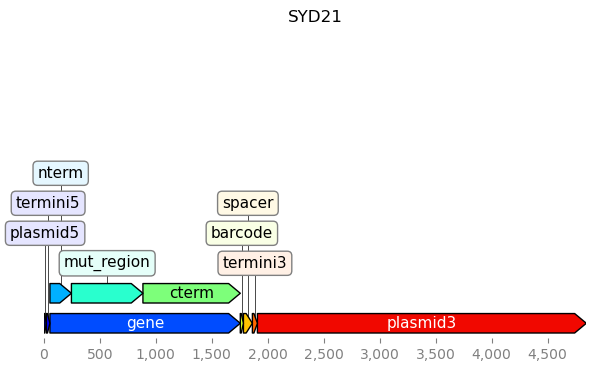

In [9]:
#generates a line plot showing the different annotations of the target, just to confirm
fig = targets.plot(ax_width=7,
                   plots_indexing='biopython',  # numbering starts at 0
                   ax_height=4,  # height of each plot
                   hspace=1.2,  # vertical space between plots
                   )

plotfile = os.path.join(config['process_ccs_dir'], 'amplicons_'+background+'.pdf')
print(f"Saving plot to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')

In [10]:
#this sets the mapper to the minimap2, use OPTIONS_CODON_DMS which is good for sequences without large deletions and/or introns
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

#This will print out the minimap2 version and the options included with OPTIONS_CODON_DMS, you can find the description of these options on bloom's website
print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.22-r1101 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


In [11]:
#this will align and parse the reads and provide the readstats for the aligned and filtered (based on the feature_parse_specs config)
#this is the longest step of the whole process
readstats, aligned, filtered = targets.align_and_parse(
        df=pacbio_runs,
        mapper=mapper,
        outdir=config['process_ccs_dir'],
        name_col='run',
        group_cols=['name', 'library'],
        queryfile_col='fastq',
        overwrite=True,
        ncpus=config['max_cpus'],
        )

In [12]:
readstats

,name,library,run,category,count
0,rep1_SI06_A,rep1,A,aligned SI06,873660
1,rep1_SI06_A,rep1,A,filtered SI06,97384
2,rep1_SI06_A,rep1,A,unmapped,24641
3,rep1_SI06_B,rep1,B,aligned SI06,841438
4,rep1_SI06_B,rep1,B,filtered SI06,101551
5,rep1_SI06_B,rep1,B,unmapped,22364
6,rep2_SI06_A,rep2,A,aligned SI06,1313702
7,rep2_SI06_A,rep2,A,filtered SI06,141226
8,rep2_SI06_A,rep2,A,unmapped,21318


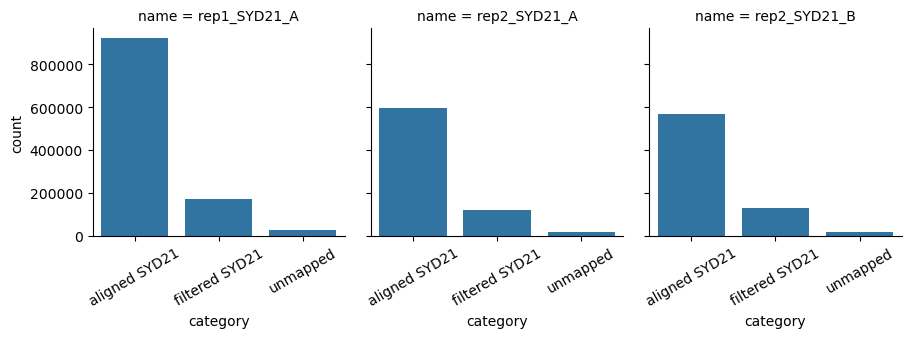

In [12]:
g = sns.FacetGrid(readstats, col='name', col_wrap=4)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

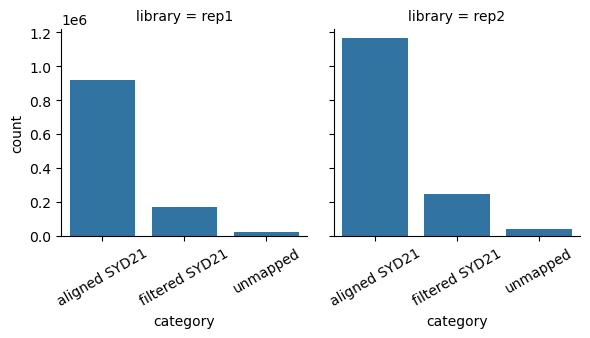

In [13]:
g = sns.FacetGrid(readstats.groupby(['library', 'category']).sum().reset_index(), col='library', col_wrap=2)
g.map_dataframe(sns.barplot, x='category', y='count')
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=30)

In [14]:
filtered_df = pd.concat(df.assign(target=target) for target, df in filtered.items())
filtered_df = filtered_df.groupby(['library', 'name', 'run', 'filter_reason']).size().rename('count').reset_index()
filtered_df['tot_reason_frac'] = filtered_df.groupby('filter_reason')['count'].transform('sum') / filtered_df['count'].sum()
other_cutoff = 0.02  # group as "other" reasons with <= this frac
filtered_df['filter_reason'] = filtered_df['filter_reason'].where(filtered_df['tot_reason_frac'] > other_cutoff, 'other')

In [15]:
pd.set_option('display.max_rows', None)
filtered_df

,library,name,run,filter_reason,count,tot_reason_frac
0,rep1,rep1_SYD21_A,A,other,418,0.002280
1,rep1,rep1_SYD21_A,A,barcode mutation_nt_count,46949,0.263488
2,rep1,rep1_SYD21_A,A,other,104,0.000565
3,rep1,rep1_SYD21_A,A,gene clip3,12253,0.057177
4,rep1,rep1_SYD21_A,A,other,312,0.001725
5,rep1,rep1_SYD21_A,A,other,12,0.000076
6,rep1,rep1_SYD21_A,A,other,24,0.000122
7,rep1,rep1_SYD21_A,A,plasmid3 clip3,37826,0.240940
8,rep1,rep1_SYD21_A,A,other,9,0.000036
9,rep1,rep1_SYD21_A,A,plasmid5 clip5,60692,0.365159


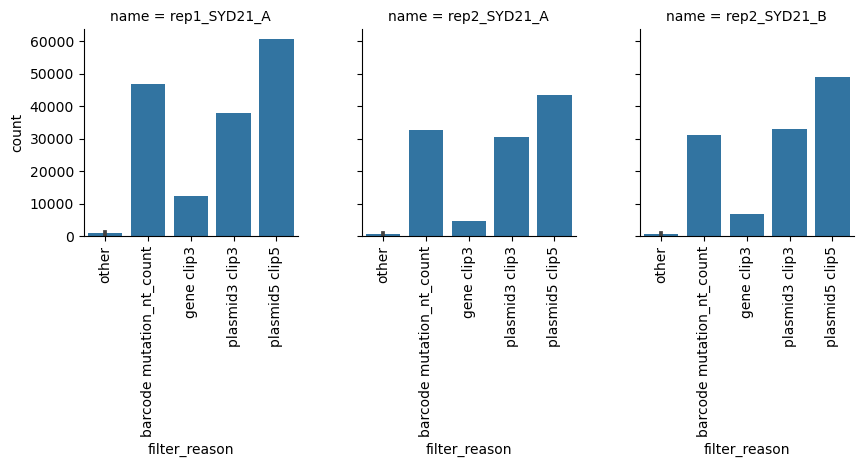

In [16]:
#plot why reads were filtered out, this can direct you to adjust the feature_parse_specs file
g = sns.FacetGrid(filtered_df, col='name')
g.map_dataframe(sns.barplot, x='filter_reason', y='count', order=filtered_df['filter_reason'].unique())
#g.tick_params(labelrotation=90)
g.set_xticklabels(rotation=90)

In [17]:
pd.set_option('display.max_rows', 10)
aligned_df = pd.concat([df.assign(target=target) for target, df in aligned.items()])
aligned_df = aligned_df.drop(columns=['query_clip5', 'query_clip3', 'run','name'])
aligned_df = aligned_df.rename(columns={'barcode_sequence': 'barcode'})
aligned_df

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target
0,rep1,m64408e_230601_183942/17/ccs,A203T ins333T ins663A ins1042G ins1183A,0.998641,,0.999994,A11T ins141T ins471A,0.998803,ins211G ins352A,0.998224,ATCTAGCCTACTAGCTGCCCAATTCCCA,0.995948,SYD21
1,rep1,m64408e_230601_183942/33/ccs,C577A T578A G579A ins1066G,0.999646,,1.000000,C385A T386A G387A,0.999859,ins235G,0.999411,ATCTGACACTAAAGCTAATAATAATATG,1.000000,SYD21
2,rep1,m64408e_230601_183942/46/ccs,T418A G419A G420T,1.000000,,1.000000,T226A G227A G228T,1.000000,,1.000000,ATCTCGCCACTTAGCTTACGAACGCCCG,1.000000,SYD21
3,rep1,m64408e_230601_183942/48/ccs,C403A C404A C405A,1.000000,,1.000000,C211A C212A C213A,1.000000,,1.000000,ATCTGAATTCTCAGCTGCTTCTCTGCAA,1.000000,SYD21
4,rep1,m64408e_230601_183942/58/ccs,G559A G561A,1.000000,,1.000000,G367A G369A,1.000000,,1.000000,ATCTATATGGGAAGCTACGAATAATCAG,1.000000,SYD21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086055,rep2,m64408e_230605_220754/180554503/ccs,G193T C195A del824to824,0.999814,,1.000000,G1T C3A del632to632,0.999504,,1.000000,ATCTCCTGAACCAGCTTATATGAAAGTG,1.000000,SYD21
2086056,rep2,m64408e_230605_220754/180554511/ccs,T250C G251T,0.999839,,0.999999,T58C G59T,0.999597,,0.999981,ATCTTGTCACCGAGCTGGTCTAGGACCC,1.000000,SYD21
2086057,rep2,m64408e_230605_220754/180554540/ccs,C793G T794A A795T,1.000000,,1.000000,C601G T602A A603T,1.000000,,1.000000,ATCTTGGCAGGAAGCTACGATACGACAG,1.000000,SYD21
2086058,rep2,m64408e_230605_220754/180554560/ccs,C773T A774G,0.999999,,1.000000,C581T A582G,1.000000,,0.999999,ATCTTCGGTTTCAGCTGCACCCTCCACC,1.000000,SYD21


In [18]:
#this saves the processed ccs file
aligned_df.to_csv(config['processed_ccs_file' + '_' + background], index=False)


print("Barcodes and mutations for valid processed CCSs "
      f"have been written to {config['processed_ccs_file' + '_' + background]}.")

Barcodes and mutations for valid processed CCSs have been written to results/process_ccs/processed_ccs_SYD21.csv.


In [19]:
os.makedirs(config['variants_dir'], exist_ok=True)
os.makedirs(config['figs_dir'], exist_ok=True)

In [20]:
processed_ccs = pd.read_csv(config['processed_ccs_file' + '_' + background], na_filter=None)

nlibs = processed_ccs['library'].nunique()  # number of unique libraries

ntargets = processed_ccs['target'].nunique()  # number of unique targets

print(f"Read {len(processed_ccs)} CCSs from {nlibs} libraries and {ntargets} targets.")

Read 2086060 CCSs from 2 libraries and 1 targets.


In [21]:
#displays number of CCSs and unique barcodes in all processed targets/reps
display_ccs = processed_ccs.groupby(['target', 'library']).aggregate(total_CCSs=('barcode', 'size'),
                                                                     unique_barcodes=('barcode', 'nunique'))
display_ccs['avg_CCSs_per_barcode'] = display_ccs['total_CCSs'] / display_ccs['unique_barcodes']
display_ccs['avg_CCSs_per_barcode'] = display_ccs['avg_CCSs_per_barcode'].round(2)

display_ccs

total_CCSs  unique_barcodes  avg_CCSs_per_barcode
target library                                                   
SYD21  rep1         921297           266013                  3.46
       rep2        1164763           256741                  4.54

In [22]:
#set max_error_rate in config.yaml file

error_rate_floor = 1e-7  # error rates < this set to this
if error_rate_floor >= config['max_error_rate']:
    raise ValueError('error_rate_floor must be < max_error_rate')
    
processed_ccs['barcode_error'] = (1-processed_ccs['barcode_accuracy']).clip(lower=error_rate_floor)
processed_ccs['gene_error'] = (1-processed_ccs['gene_accuracy']).clip(lower=error_rate_floor)

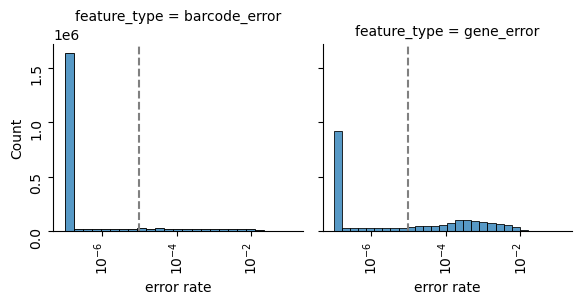

In [23]:
#plot error rates
g = sns.FacetGrid(processed_ccs.melt(value_vars=['barcode_error', 'gene_error'],
              var_name='feature_type', value_name='error rate'), col='feature_type')
g.map_dataframe(sns.histplot, x='error rate', bins=25, log_scale=True)
g.refline(x=config['max_error_rate'])
g.tick_params(labelrotation=90)

In [24]:
processed_ccs['retained'] = ((processed_ccs['gene_error'] < config['max_error_rate']) &
                              (processed_ccs['barcode_error']    < config['max_error_rate']))

In [25]:
#retained based on error rate
data = processed_ccs.assign(xlabel=lambda x: x['target'] + ', ' + x['library']).groupby(['xlabel', 'retained']).size().rename('count').reset_index()
data

,xlabel,retained,count
0,"SYD21, rep1",False,399980
1,"SYD21, rep1",True,521317
2,"SYD21, rep2",False,524441
3,"SYD21, rep2",True,640322


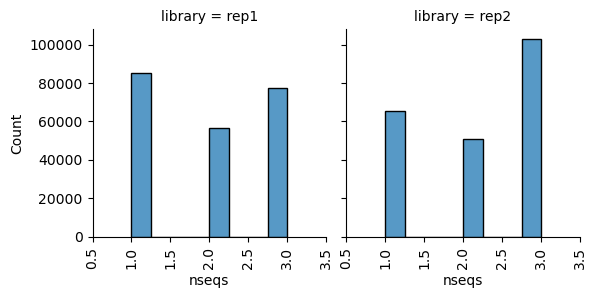

In [26]:
#plot histogram for how many barcodes have how many CCSs associated with them
max_count = 3 # in plot, group all barcodes with >= this many counts

data = processed_ccs.query('retained').groupby(['library', 'barcode']).size().rename('nseqs').reset_index()
data['nseqs'] = data['nseqs'].clip(upper=max_count)

g = sns.FacetGrid(data, col='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=8)
#g.tick_params(labelrotation=90)
plt.yticks(rotation=45)
g.set_xticklabels(rotation=90)

In [27]:
processed_ccs = processed_ccs.reset_index(drop=True)

#add indel columns, what you put as mutation_col is where it will look to see if there are indels there
processed_ccs = alignparse.consensus.add_mut_info_cols(processed_ccs,
                                                       mutation_col=considered_region,
                                                       n_indel_col='n_indels',
                                                       del_str_col='del',
                                                       n_del_col='n_dels',
                                                       n_ins_col='n_ins')

processed_ccs['has_indel'] = (processed_ccs['n_indels'] > 0).astype(bool)
processed_ccs['has_ins'] = (processed_ccs['n_ins'] > 0).astype(bool)
processed_ccs['has_del'] = (processed_ccs['n_dels'] > 0).astype(bool)

In [28]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
processed_ccs

,library,query_name,gene_mutations,gene_accuracy,nterm_mutations,nterm_accuracy,mut_region_mutations,mut_region_accuracy,cterm_mutations,cterm_accuracy,barcode,barcode_accuracy,target,barcode_error,gene_error,retained,del,n_dels,n_ins,n_indels,has_indel,has_ins,has_del
0,rep1,m64408e_230601_183942/17/ccs,A203T ins333T ins663A ins1042G ins1183A,0.998641,,0.999994,A11T ins141T ins471A,0.998803,ins211G ins352A,0.998224,ATCTAGCCTACTAGCTGCCCAATTCCCA,0.995948,SYD21,4.052018e-03,1.359043e-03,False,,0,4,4,True,True,False
1,rep1,m64408e_230601_183942/33/ccs,C577A T578A G579A ins1066G,0.999646,,1.000000,C385A T386A G387A,0.999859,ins235G,0.999411,ATCTGACACTAAAGCTAATAATAATATG,1.000000,SYD21,1.000000e-07,3.544158e-04,False,,0,1,1,True,True,False
2,rep1,m64408e_230601_183942/46/ccs,T418A G419A G420T,1.000000,,1.000000,T226A G227A G228T,1.000000,,1.000000,ATCTCGCCACTTAGCTTACGAACGCCCG,1.000000,SYD21,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
3,rep1,m64408e_230601_183942/48/ccs,C403A C404A C405A,1.000000,,1.000000,C211A C212A C213A,1.000000,,1.000000,ATCTGAATTCTCAGCTGCTTCTCTGCAA,1.000000,SYD21,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
4,rep1,m64408e_230601_183942/58/ccs,G559A G561A,1.000000,,1.000000,G367A G369A,1.000000,,1.000000,ATCTATATGGGAAGCTACGAATAATCAG,1.000000,SYD21,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086055,rep2,m64408e_230605_220754/180554503/ccs,G193T C195A del824to824,0.999814,,1.000000,G1T C3A del632to632,0.999504,,1.000000,ATCTCCTGAACCAGCTTATATGAAAGTG,1.000000,SYD21,1.000000e-07,1.862510e-04,False,del824to824,1,0,1,True,False,True
2086056,rep2,m64408e_230605_220754/180554511/ccs,T250C G251T,0.999839,,0.999999,T58C G59T,0.999597,,0.999981,ATCTTGTCACCGAGCTGGTCTAGGACCC,1.000000,SYD21,1.000000e-07,1.609939e-04,False,,0,0,0,False,False,False
2086057,rep2,m64408e_230605_220754/180554540/ccs,C793G T794A A795T,1.000000,,1.000000,C601G T602A A603T,1.000000,,1.000000,ATCTTGGCAGGAAGCTACGATACGACAG,1.000000,SYD21,1.000000e-07,1.000000e-07,True,,0,0,0,False,False,False
2086058,rep2,m64408e_230605_220754/180554560/ccs,C773T A774G,0.999999,,1.000000,C581T A582G,1.000000,,0.999999,ATCTTCGGTTTCAGCTGCACCCTCCACC,1.000000,SYD21,1.000000e-07,7.406218e-07,True,,0,0,0,False,False,False


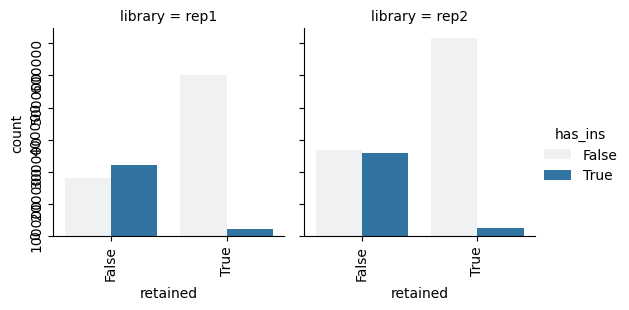

In [29]:
#plot whether the sequences retained after the error rate filter have insertions

g = sns.FacetGrid(processed_ccs, col='library')
g.map_dataframe(sns.countplot, x='retained', hue='has_ins')
g.tick_params(labelrotation=90)
g.add_legend(title='has_ins')

In [30]:
high_acc = config['max_error_rate'] / 10
empirical_acc = []

for desc, query_str in [
        ('retained', 'retained'),
        ('retained, no ins', 'retained and not has_ins'),
        ('10X accuracy', f"(gene_error < {high_acc}) and (barcode_error < {high_acc})"),
        ('10X accuracy, no ins', f"(gene_error < {high_acc}) and (barcode_error < {high_acc}) and not has_ins")
        ]:
    # get just CCSs in that category
    query_df = processed_ccs.query(query_str)
        
    # compute empirical accuracy
    emp_acc_df = alignparse.consensus.empirical_accuracy(query_df,
                                                mutation_col=considered_region,
                                                group_cols='barcode',
                                                accuracy_col='accuracy',
                                               )
    emp_acc_df['description'] = desc
    query_df = emp_acc_df.merge(query_df.groupby('library').size().rename('number_CCSs').reset_index())
    empirical_acc.append(query_df)

# make description categorical to preserve order, and annotate as "actual"
# the category ("retained, no indel") that we will use for building variants.
empirical_acc = pd.concat(empirical_acc, ignore_index=True, sort=False)
empirical_acc['description'] = pd.Categorical(empirical_acc['description'],
                                                 empirical_acc['description'].unique(),
                                                 ordered=True)
empirical_acc['actual'] = np.where(empirical_acc['description'] == 'retained, no ins', True, False)

In [31]:
empirical_acc

,library,accuracy,description,number_CCSs,actual
0,rep1,0.923063,retained,521317,False
1,rep2,0.920868,retained,640322,False
2,rep1,0.957464,"retained, no ins",500471,True
3,rep2,0.953519,"retained, no ins",615761,True
4,rep1,0.940718,10X accuracy,457827,False
5,rep2,0.939542,10X accuracy,556167,False
6,rep1,0.963481,"10X accuracy, no ins",445159,False
7,rep2,0.962266,"10X accuracy, no ins",540832,False


In [32]:
consensus, dropped = alignparse.consensus.simple_mutconsensus(
                        processed_ccs.query('retained'),
                        group_cols=('library', 'barcode', 'target'),
                        mutation_col=considered_region,
                        )

consensus.head()

,library,barcode,target,gene_mutations,variant_call_support
0,rep1,AAAGCTATAACTAGCTGCTTACGAATCA,SYD21,T653C G654A ins1702ATCTGTCGGG,2
1,rep1,AAAGGGTAAGCTAGCTACGATCTAAAGT,SYD21,C598A C599G T600A ins1702ATCT,2
2,rep1,AACACTGGTGCTAGCTCGATTCTTCAAA,SYD21,T379G C380G ins1702ATCTATCCGACGAGCTCGATAGC,5
3,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,SYD21,A826C A827T A828T,1
4,rep1,AACTGGGACTACAGCTACATCTCACTTC,SYD21,A676T A677C G678A,1


In [33]:
consensus = alignparse.consensus.add_mut_info_cols(
                    consensus,
                    mutation_col=considered_region,
                    sub_str_col='substitutions',
                    n_indel_col='number_of_indels',
                    n_ins_col='number_of_insertions',
                    n_del_col='number_of_deletions',
                    del_str_col='deletion',
                    overwrite_cols=True)

consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,deletion,number_of_deletions,number_of_insertions,number_of_indels
0,rep1,AAAGCTATAACTAGCTGCTTACGAATCA,SYD21,T653C G654A ins1702ATCTGTCGGG,2,T653C G654A,,0,1,1
1,rep1,AAAGGGTAAGCTAGCTACGATCTAAAGT,SYD21,C598A C599G T600A ins1702ATCT,2,C598A C599G T600A,,0,1,1
2,rep1,AACACTGGTGCTAGCTCGATTCTTCAAA,SYD21,T379G C380G ins1702ATCTATCCGACGAGCTCGATAGC,5,T379G C380G,,0,1,1
3,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,SYD21,A826C A827T A828T,1,A826C A827T A828T,,0,0,0
4,rep1,AACTGGGACTACAGCTACATCTCACTTC,SYD21,A676T A677C G678A,1,A676T A677C G678A,,0,0,0
...,...,...,...,...,...,...,...,...,...,...
419971,rep2,TTGCGGTCCATTAGCTGCGATCGCCCCC,SYD21,A388C G389A G390T,1,A388C G389A G390T,,0,0,0
419972,rep2,TTGCGTACATCCAGCTCGGATGGTGCCT,SYD21,A424G A425G T426A,2,A424G A425G T426A,,0,0,0
419973,rep2,TTGCTAAGTACCAGCTCTACCAAAATGC,SYD21,G328A G329A A330T,1,G328A G329A A330T,,0,0,0
419974,rep2,TTGCTCACGCTCAGCTAGATATACAATC,SYD21,G238T A240C,5,G238T A240C,,0,0,0


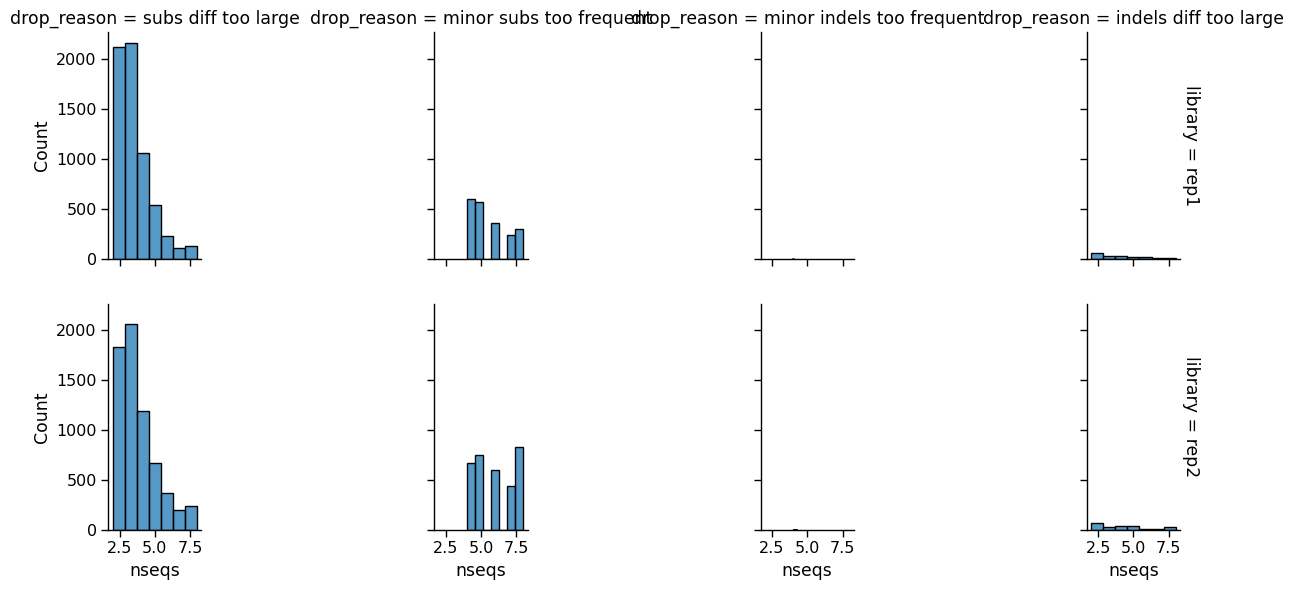

In [34]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

#below is from https://wckdouglas.github.io/2016/12/seaborn_annoying_title
with sns.plotting_context('paper', font_scale = 1.3):
    p = sns.FacetGrid(data = dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                      col = 'drop_reason',
                      row = 'library',
                      margin_titles=True)
    
p.map_dataframe(sns.histplot, x='nseqs', bins=7) 
plt.subplots_adjust(hspace=0.2, wspace=2.5)

In [35]:
max_variant_call_support = 6  # group variants with >= this much support
consensus['variant_call_support'] = consensus['variant_call_support'].clip(upper=max_variant_call_support)
consensus['ins_state'] = np.where(consensus['number_of_insertions'] > 0, 'has ins', 'no ins')

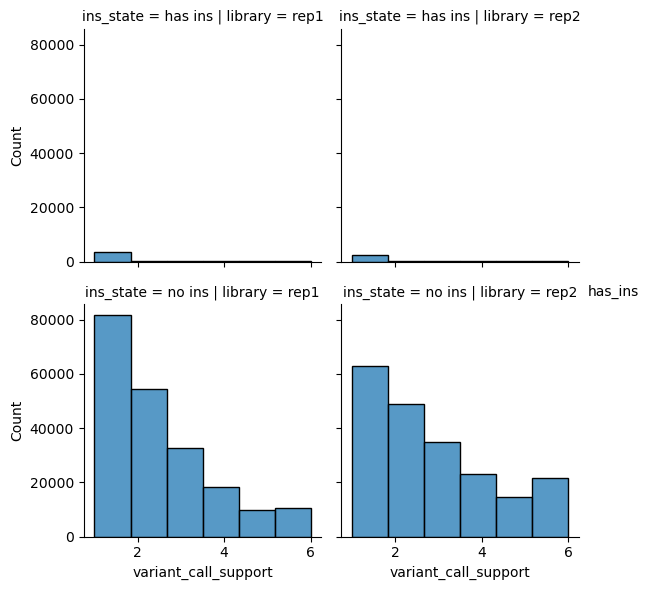

In [36]:
g = sns.FacetGrid(consensus, col='library', row='ins_state')
g.map_dataframe(sns.histplot, x='variant_call_support', bins=6)
g.add_legend(title='has_ins')

In [37]:
consensus=consensus.query('number_of_insertions == 0')
consensus=consensus.query('number_of_deletions <= 1')

In [38]:
#change dels to -, determine if deletion is out of frame and remove any that are not in frame
if considered_region == 'gene_mutations':
    region_seq = targets.get_target(background).get_feature('gene').seq
if considered_region == 'mut_region_mutations':
    region_seq = targets.get_target(background).get_feature('mut_region').seq
    
consensus.reset_index(drop=True)

deltosubs=InFrameDeletionsToSubs(region_seq)
new_subs=[]
for x in consensus[considered_region]:  
    new_subs.append(deltosubs.dels_to_subs(x))
consensus['substitutions']=new_subs
consensus['deletion_out_of_frame']=consensus['substitutions'].str.contains('del')
consensus=consensus[consensus['deletion_out_of_frame']==False]
consensus=consensus.drop(['deletion'],axis='columns')
consensus

,library,barcode,target,gene_mutations,variant_call_support,substitutions,number_of_deletions,number_of_insertions,number_of_indels,ins_state,deletion_out_of_frame
3,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,SYD21,A826C A827T A828T,1,A826C A827T A828T,0,0,0,no ins,False
4,rep1,AACTGGGACTACAGCTACATCTCACTTC,SYD21,A676T A677C G678A,1,A676T A677C G678A,0,0,0,no ins,False
58,rep1,AGCTCCTCATGAAGCTTGTAGGAACGGG,SYD21,A301T T303A,5,A301T T303A,0,0,0,no ins,False
71,rep1,ATATAAAGGGTAAGCTCTAGTCACTTTA,SYD21,C598G T600A,2,C598G T600A,0,0,0,no ins,False
72,rep1,ATATAAAGGGTAAGCTTAAGATATCCTC,SYD21,C598G T600A,3,C598G T600A,0,0,0,no ins,False
...,...,...,...,...,...,...,...,...,...,...,...
419971,rep2,TTGCGGTCCATTAGCTGCGATCGCCCCC,SYD21,A388C G389A G390T,1,A388C G389A G390T,0,0,0,no ins,False
419972,rep2,TTGCGTACATCCAGCTCGGATGGTGCCT,SYD21,A424G A425G T426A,2,A424G A425G T426A,0,0,0,no ins,False
419973,rep2,TTGCTAAGTACCAGCTCTACCAAAATGC,SYD21,G328A G329A A330T,1,G328A G329A A330T,0,0,0,no ins,False
419974,rep2,TTGCTCACGCTCAGCTAGATATACAATC,SYD21,G238T A240C,5,G238T A240C,0,0,0,no ins,False


In [39]:
print(f"Writing nucleotide variants to {config['nt_variant_table_file' + '_' + background]}")
      
(consensus
 [['target', 'library', 'barcode', considered_region,'substitutions', 'variant_call_support']]
 .to_csv(config['nt_variant_table_file' + '_' + background], index=False)
 )
      
print('Here are the first few lines of this file:')
display(HTML(
    pd.read_csv(config['nt_variant_table_file' + '_' + background], na_filter=None)
    .head()
    .to_html(index=False)
    )) 

Writing nucleotide variants to results/variants/nucleotide_variant_table_SYD21.csv
Here are the first few lines of this file:


target,library,barcode,gene_mutations,substitutions,variant_call_support
SYD21,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,A826C A827T A828T,A826C A827T A828T,1
SYD21,rep1,AACTGGGACTACAGCTACATCTCACTTC,A676T A677C G678A,A676T A677C G678A,1
SYD21,rep1,AGCTCCTCATGAAGCTTGTAGGAACGGG,A301T T303A,A301T T303A,5
SYD21,rep1,ATATAAAGGGTAAGCTCTAGTCACTTTA,C598G T600A,C598G T600A,2
SYD21,rep1,ATATAAAGGGTAAGCTTAAGATATCCTC,C598G T600A,C598G T600A,3


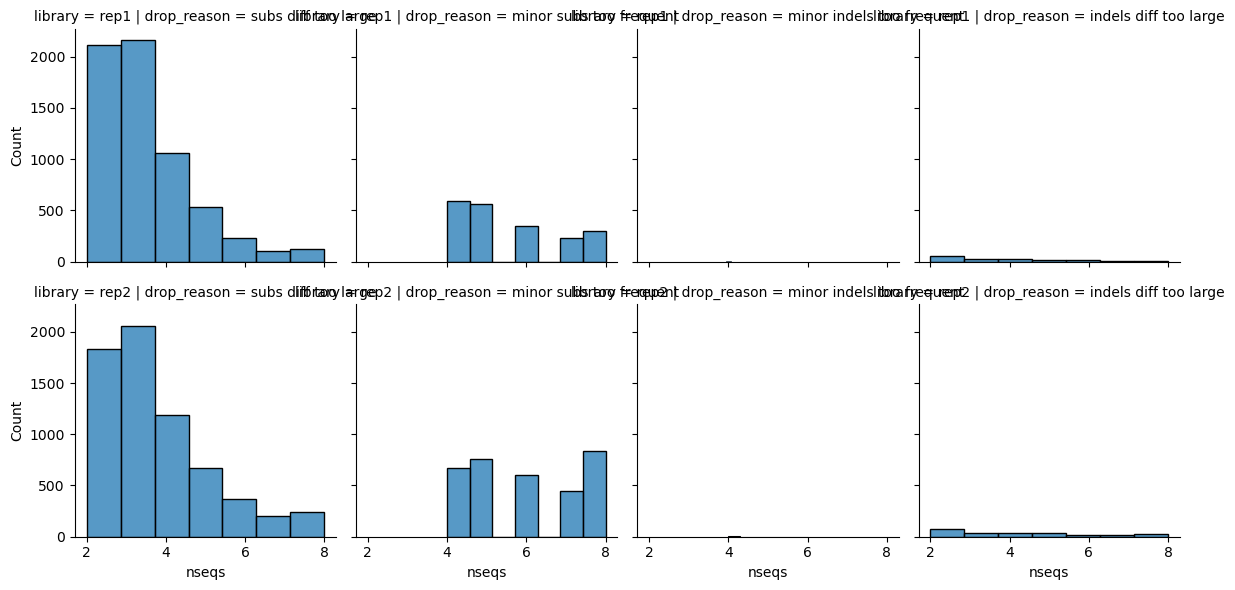

In [40]:
max_nseqs = 8  # plot together all barcodes with >= this many sequences

g = sns.FacetGrid(dropped.assign(nseqs=lambda x: np.clip(x['nseqs'], None, max_nseqs)),
                  col='drop_reason', row='library')
g.map_dataframe(sns.histplot, x='nseqs', bins=7)


In [41]:
targets = alignparse.targets.Targets(seqsfile=config['amplicons_' + background],
                                     feature_parse_specs=config['feature_parse_specs_' + background])
geneseq = targets.get_target(background).get_feature('gene').seq

print(f"Read gene of {len(geneseq)} nts for {background} from {config['amplicons_' + background]}")
     

Read gene of 1701 nts for SYD21 from data/SYD21.gb


In [42]:
variants = dms_variants.codonvarianttable.CodonVariantTable(
                barcode_variant_file=config['nt_variant_table_file_' + background],
                geneseq=geneseq,
                primary_target=background,
                allowgaps=True,
                substitutions_col='substitutions'
                )

In [43]:
print('Number of variants for each replicate:')
display(HTML(
    variants
    .n_variants_df(samples=None)
    .pivot_table(index=['target'],
                 columns='library',
                 values='count')
    .to_html()
    ))

Number of variants for each replicate:


library,rep1,rep2,all libraries
target,,,
SYD21,204146,203466,407612


In [44]:
variants_df=variants.barcode_variant_df
variants_df

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,SYD21,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,1,AAA276CTT,K276L,1,1
1,SYD21,rep1,AACTGGGACTACAGCTACATCTCACTTC,1,AAG226TCA,K226S,1,1
2,SYD21,rep1,AGCTCCTCATGAAGCTTGTAGGAACGGG,5,AAT101TAA,N101*,1,1
3,SYD21,rep1,ATATAAAGGGTAAGCTCTAGTCACTTTA,2,CCT200GCA,P200A,1,1
4,SYD21,rep1,ATATAAAGGGTAAGCTTAAGATATCCTC,3,CCT200GCA,P200A,1,1
...,...,...,...,...,...,...,...,...
407607,SYD21,rep2,TTGCGGTCCATTAGCTGCGATCGCCCCC,1,AGG130CAT,R130H,1,1
407608,SYD21,rep2,TTGCGTACATCCAGCTCGGATGGTGCCT,2,AAT142GGA,N142G,1,1
407609,SYD21,rep2,TTGCTAAGTACCAGCTCTACCAAAATGC,1,GGA110AAT,G110N,1,1
407610,SYD21,rep2,TTGCTCACGCTCAGCTAGATATACAATC,5,GGA80TGC,G80C,1,1


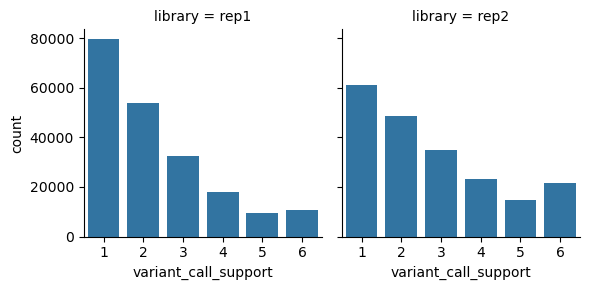

In [45]:
#show distribution of sequences with x number of ccs supporting each variant
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='variant_call_support')
g.tick_params(labelrotation=0)

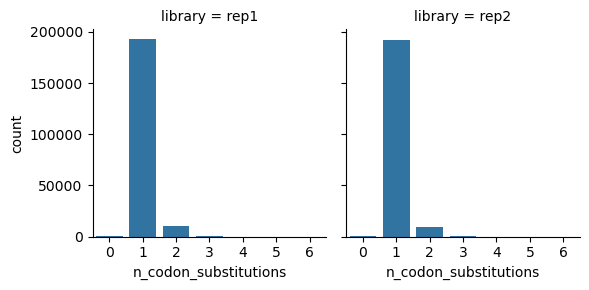

In [46]:
#show distribution of sequences with x number of codon substitutions
g = sns.FacetGrid(variants_df, col='library')
g.map_dataframe(sns.countplot, x='n_codon_substitutions')
g.tick_params(labelrotation=0)

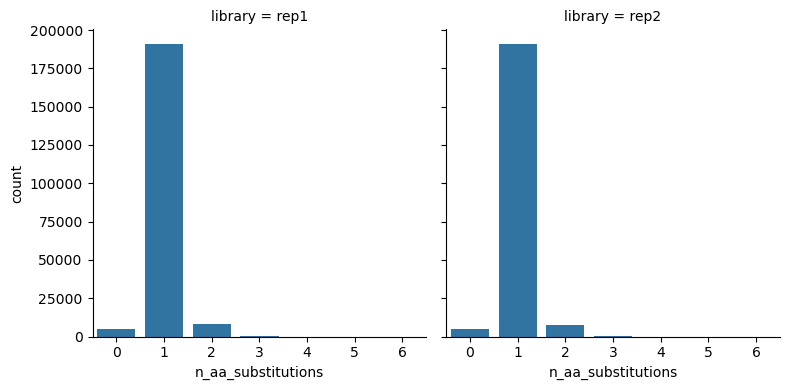

In [47]:
#show distribution of sequences with x number of amino acid substitutions
g = sns.FacetGrid(variants_df, col='library', height=4)
g.map_dataframe(sns.countplot, x='n_aa_substitutions')
g.tick_params(labelrotation=0)

In [48]:
display(HTML(
    variants.barcode_variant_df
    .head()
    .to_html(index=False)
    ))

target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
SYD21,rep1,AACTACGAGTTCAGCTGTCGTGCGCACC,1,AAA276CTT,K276L,1,1
SYD21,rep1,AACTGGGACTACAGCTACATCTCACTTC,1,AAG226TCA,K226S,1,1
SYD21,rep1,AGCTCCTCATGAAGCTTGTAGGAACGGG,5,AAT101TAA,N101*,1,1
SYD21,rep1,ATATAAAGGGTAAGCTCTAGTCACTTTA,2,CCT200GCA,P200A,1,1
SYD21,rep1,ATATAAAGGGTAAGCTTAAGATATCCTC,3,CCT200GCA,P200A,1,1


In [49]:
print(f"Writing codon-variant table to {config['codon_variant_table_file_'+background]}")
print(f"Writing single codon-variant table to {config['codon_variant_table_file_'+background+'_single']}")


variants_df=variants.barcode_variant_df
variants_df.to_csv(config['codon_variant_table_file_'+background], index=False)
variants_df.query('n_codon_substitutions <= 1').to_csv(config['codon_variant_table_file_'+background+'_single'], index=False)

Writing codon-variant table to results/variants/codon_variant_table_SYD21.csv
Writing single codon-variant table to results/variants/codon_variant_table_SYD21_single.csv
